In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

In [5]:
task = 'aggression_score'

time: 773 µs


### Load Annotated Data

In [3]:
d_b, d_r = load_cf_data()

time: 15.8 s


In [6]:
# map to 3 classes
l_b = plurality(d_b[task].dropna().apply(map_aggression_score_to_3class))
l_r = plurality(d_r[task].dropna().apply(map_aggression_score_to_3class))

time: 29.7 s


In [7]:
l_r.value_counts()

1    17753
2     1913
0      326
Name: y, dtype: int64

time: 58.3 ms


In [8]:
l_b.value_counts()

1    38049
0    13704
2     1662
Name: y, dtype: int64

time: 13.2 ms


In [9]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 2.13 s


### Split into train/dev and test

In [10]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 58.2 ms


In [11]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 13.2 ms


In [12]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 4.9 ms


In [13]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

19

time: 40 ms


### NGram Classification Pipeline

In [11]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'lbfgs')),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (15000,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,5),),  
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (1.0,5,10),
    'clf__multi_class' : ('multinomial',),
    'clf__class_weight': ('balanced',None)

}

time: 29.4 ms


### Hyper-Parameter tuning

In [12]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'f1_micro', n_jobs=8, verbose=True)


Best parameters set found:
{'vect__ngram_range': (1, 5), 'clf__C': 5, 'clf__multi_class': 'multinomial', 'vect__max_features': 15000, 'vect__analyzer': 'char', 'clf__class_weight': None} 0.734091785577


Grid scores:
0.62090 (+/-0.00379) for {'vect__ngram_range': (1, 5), 'clf__C': 1.0, 'clf__multi_class': 'multinomial', 'vect__max_features': 15000, 'vect__analyzer': 'char', 'clf__class_weight': 'balanced'}
0.73101 (+/-0.00126) for {'vect__ngram_range': (1, 5), 'clf__C': 1.0, 'clf__multi_class': 'multinomial', 'vect__max_features': 15000, 'vect__analyzer': 'char', 'clf__class_weight': None}
0.64857 (+/-0.00062) for {'vect__ngram_range': (1, 5), 'clf__C': 5, 'clf__multi_class': 'multinomial', 'vect__max_features': 15000, 'vect__analyzer': 'char', 'clf__class_weight': 'balanced'}
0.73409 (+/-0.00069) for {'vect__ngram_range': (1, 5), 'clf__C': 5, 'clf__multi_class': 'multinomial', 'vect__max_features': 15000, 'vect__analyzer': 'char', 'clf__class_weight': None}
0.66140 (+/-0.00093) for {

In [14]:
## Be very careful to transcribe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 5.0, class_weight = None, multi_class= 'multinomial', solver = 'lbfgs')),
])

time: 30.1 ms


### Train on blocked

In [15]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 2min 27s


Eval on blocked


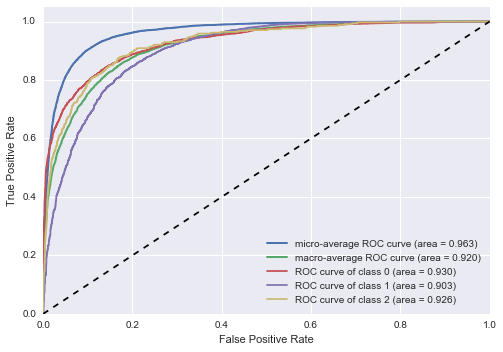

time: 23.2 s


In [16]:
print('Eval on blocked')
_= eval_multiclass_classifier(b_model, b_test)

Eval on random


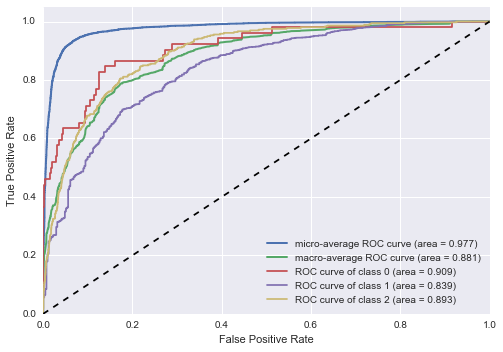

time: 9.29 s


In [17]:
print('Eval on random')
_= eval_multiclass_classifier(b_model, r_test)

### Train on random

In [18]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 1min 4s


Eval on blocked


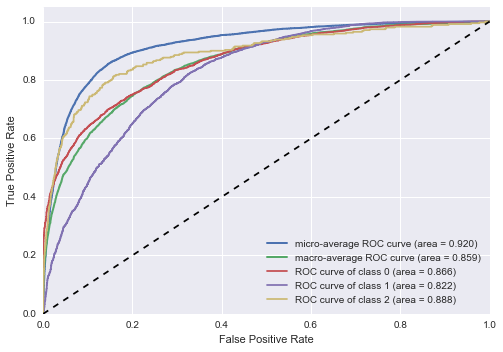

time: 26.1 s


In [19]:
print('Eval on blocked')
_= eval_multiclass_classifier(r_model, b_test)

Eval on random


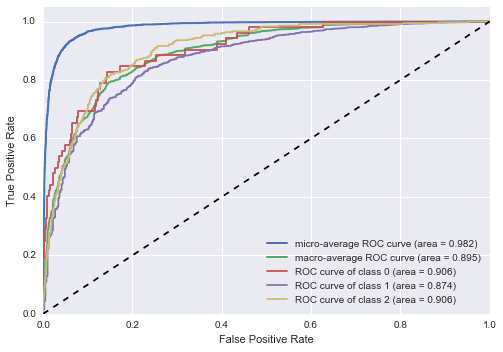

time: 9.21 s


In [20]:
print('Eval on random')
_= eval_multiclass_classifier(r_model, r_test)

### Train on both

In [21]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 3min 43s


Eval on blocked


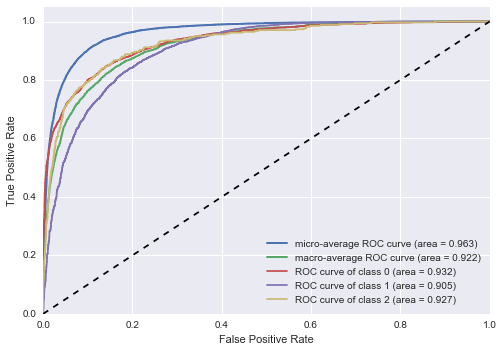

time: 29.3 s


In [22]:
print('Eval on blocked')
_= eval_multiclass_classifier(br_model, b_test)

Eval on random


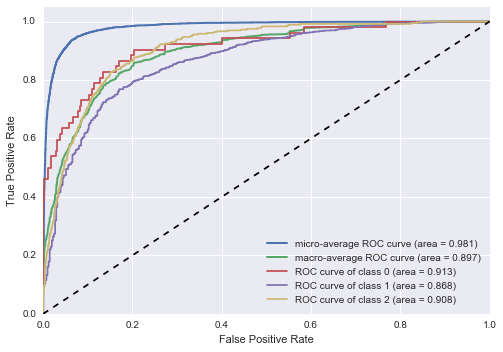

time: 10.2 s


In [23]:
print('Eval on random')
_= eval_multiclass_classifier(br_model, r_test)

Eval on both


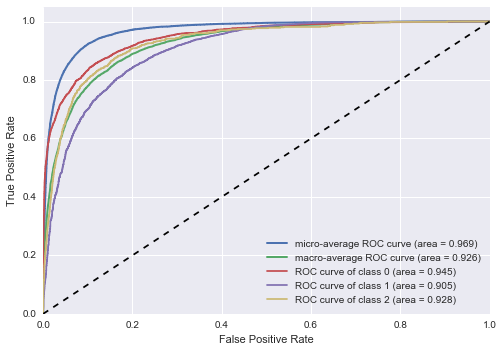

time: 35.6 s


In [24]:
print('Eval on both')
_= eval_multiclass_classifier(br_model, br_test)

### Check Calibration

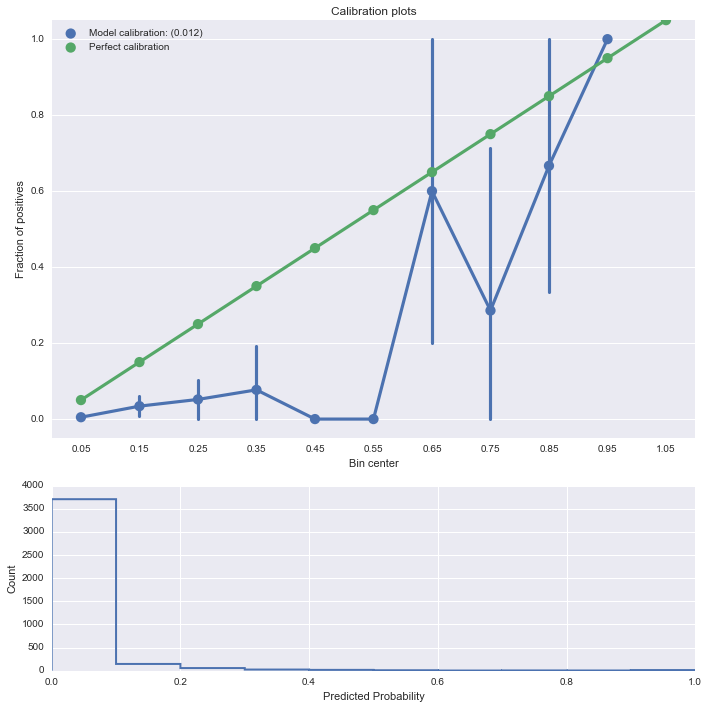

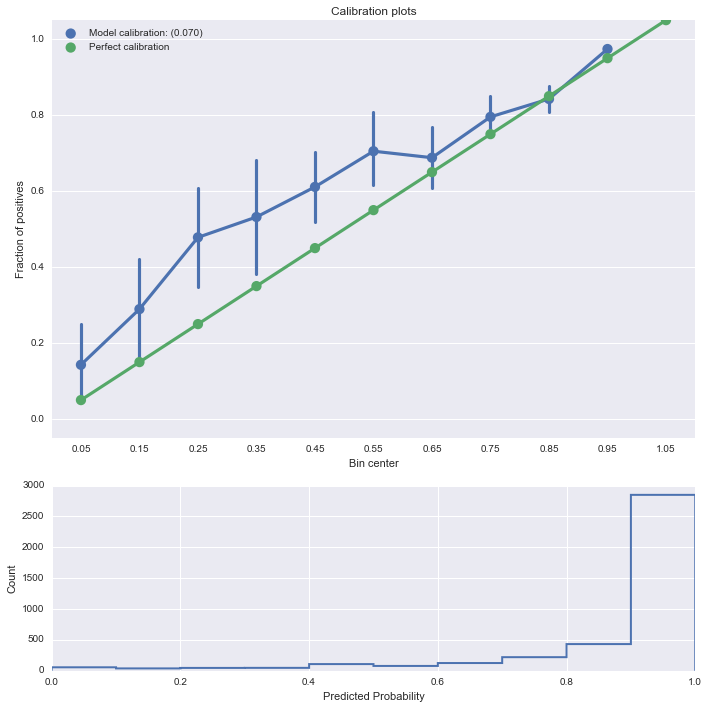

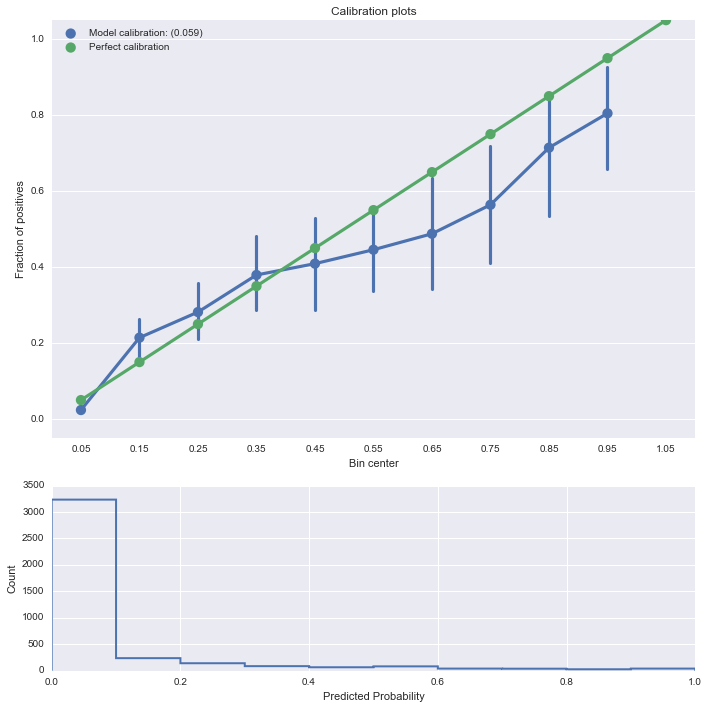

time: 17.8 s


In [25]:
# Not done
classes = [0, 1, 2]
test_binarized = label_binarize(r_test['y'], classes)
test_probas = br_model.predict_proba(r_test['x'])
for i in classes:
    plt.figure()
    calibration_curve_plotter(test_binarized[:, i], test_probas[:, i])
    plt.show()

### Error Analysis

In [27]:
#fn, fp = get_clf_errors(br_model, br_test)

time: 847 µs


In [28]:
# extreme False negatives
#print_clf_errors(fn)

time: 1 ms


In [29]:
# extreme False positives
#print_clf_errors(fp)

time: 1.1 ms


### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked dat as we add more training data.

In [26]:
def get_roc(model, test):
    y_test = label_binarize(test['y'], range(3)).ravel()
    y_score = model.predict_proba(test['x']).ravel()
    fpr, tpr, _ = roc_curve(y_test, y_score)
    return auc(fpr, tpr)

time: 3.22 ms


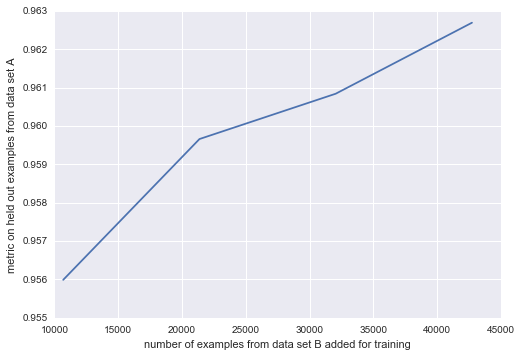

time: 8min 32s


In [27]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_roc)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

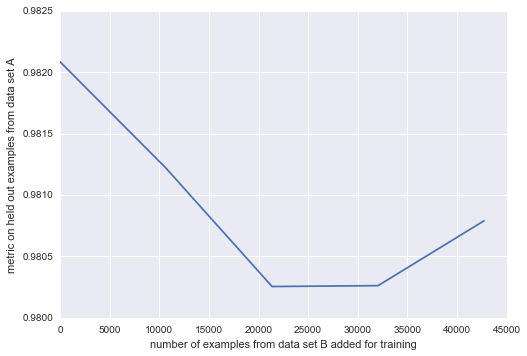

time: 12min 54s


In [28]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train, get_roc)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

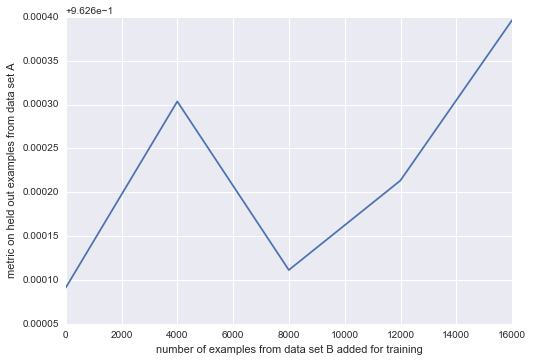

time: 12min 48s


In [29]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_roc)
plot_adding_other_data(ms, metrics)

# Final Model

In [30]:
br_data = pd.concat([data_r,data_b])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/aggression_classification_ngram.pkl')

['../../models/aggression_classification_ngram.pkl',
 '../../models/aggression_classification_ngram.pkl_01.npy',
 '../../models/aggression_classification_ngram.pkl_02.npy',
 '../../models/aggression_classification_ngram.pkl_03.npy',
 '../../models/aggression_classification_ngram.pkl_04.npy',
 '../../models/aggression_classification_ngram.pkl_05.npy',
 '../../models/aggression_classification_ngram.pkl_06.npy']

time: 3min 45s
